Hepsiemlak.com sitesinden Bursa iline ait kiralık ilan bilgileri kazınıp, makine öğrenimi algoritmaları ile kira ücreti tahmin modeli ortaya konmaya çalışılmıştır.

In [1]:
import requests
from bs4 import BeautifulSoup
import time
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV,Lasso,LassoCV,ElasticNet,ElasticNetCV
import sklearn.metrics as mt
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor

In [3]:
ad=[]
oda=[]
buyukluk=[]
bina_yasi=[]
kat=[]
semt=[]
fiyat=[]

for sayfa in range(1,20):
    url="https://www.hepsiemlak.com/bursa-kiralik?page={}".format(sayfa)
    parser=BeautifulSoup(requests.get(url).content, "html.parser")
    veri=parser.find("div",{"class":"listView"}).find_all("li",{"class":"listing-item"})
    for i in range(len(veri)):
        ad.append(veri[i].find("div",{"class":"card-bottom-cage"}).find("h3").text.strip())
        oda.append(veri[i].find("span",{"class":"celly houseRoomCount"}).find("span").text)
        buyukluk.append(veri[i].find("span",{"class":"celly squareMeter list-view-size"}).find("span").text.strip().split()[0])
        bina_yasi.append(veri[i].find("span",{"class":"celly buildingAge"}).find("span").text.strip())
        kat.append(veri[i].find("span",{"class":"celly floortype"}).text.strip())
        semt.append(veri[i].find("div",{"class":"list-view-location"}).find("span").text.split())
        fiyat.append(veri[i].find("div",{"class":"top"}).find("span",{"class":"list-view-price"}).text.split()[0])
 

In [4]:
data=pd.DataFrame({"ilan_adi":ad,"oda_sayisi":oda,"buyukluk":buyukluk,"bina_yasi":bina_yasi,
                  "kat":kat,"semt":semt,"fiyat":fiyat})
data.head()

,ilan_adi,oda_sayisi,buyukluk,bina_yasi,kat,semt,fiyat
0,sezonluk eşyalı güzelyalı feribot yakını site ...,2 + 1,110,40,Asma Kat,"[Mudanya,]",100.000
1,sezonluk mudanya istasyon caddesinde eşyalı 3...,3 + 1,120,40,En Üst Kat,"[Mudanya,]",70.000
2,"fsm caddesine cephe 3+1 ferah, ara katta, otop...",3 + 1,145,15,3. Kat,"[Nilüfer,]",11.000
3,bursa nilüfer beşevler konak cd kiralık 2.kat ...,3 + 1,140,25,2. Kat,"[Nilüfer,]",9.000
4,bursa gemlik kumlada full deniz manzaralı eşya...,3 + 1,150,20,4. Kat,"[Gemlik,]",20.000


In [4]:
import re

semt2=[]
fiyat2=[]
for i in range(len(data)):
    duzenle=str(data["semt"][i]).replace("[","").replace("]","").replace("'","").replace(",","")
    duzenle2=str(data["fiyat"][i]).replace(".","")
    semt2.append(duzenle)
    fiyat2.append(duzenle2)

data["semt"]=semt2
data["fiyat"]=fiyat2
data.head()


,ilan_adi,oda_sayisi,buyukluk,bina_yasi,kat,semt,fiyat
0,zümeüt ten ihsaaniye de boş hemen taşın kiralı...,3 + 1,140,16,5. Kat,Nilüfer,10500
1,cio gayrimenkul'den kiralık bakımlı daire,2 + 1,115,25,2. Kat,Yıldırım,5750
2,kasa gayrimenkul'den görükle de eşyalı 1+1 kir...,1 + 1,65,10,3. Kat,Nilüfer,4500
3,"bk yatırım'dan,mudanya'da full deniz manzaralı...",4 + 1,300,2,5. Kat,Mudanya,15000
4,bursa nilüfer beşevler konak mh kiralık 2.kat ...,3 + 1,150,25,2. Kat,Nilüfer,10000


In [5]:
data.isnull().sum()

ilan_adi      0
oda_sayisi    0
buyukluk      0
bina_yasi     0
kat           0
semt          0
fiyat         0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ilan_adi    446 non-null    object
 1   oda_sayisi  446 non-null    object
 2   buyukluk    446 non-null    object
 3   bina_yasi   446 non-null    object
 4   kat         446 non-null    object
 5   semt        446 non-null    object
 6   fiyat       446 non-null    object
dtypes: object(7)
memory usage: 24.5+ KB


In [7]:
data["bina_yasi"].unique()

array(['16', '25', '10', '2', '20', '40', '6', '29', '35', '1', '12', '7',
       '3', 'Sıfır Bina', '26', '30', '15', '23', '8', '4', '5', '11',
       '27', '31', '21', '14', '13', '18', '50', '28', '22', '100', '19'],
      dtype=object)

In [8]:
data["oda_sayisi"].unique()

array(['3 + 1', '2 + 1', '1 + 1', '4 + 1', 'Stüdyo', '5 + 1', '2 + 11',
       '5 + 2', '2 + 2', '1 + 3', '2 + 0', '6 + 1', '3 + 2', '16 + 4'],
      dtype=object)

In [9]:
data["kat"].unique()

array(['5. Kat', '2. Kat', '3. Kat', '4. Kat', 'Asma Kat', 'Giriş Katı',
       'En Üst Kat', '1. Kat', 'Bahçe Katı', '6. Kat', 'Ara Kat',
       '7. Kat', 'Yüksek Giriş', '10. Kat', '9. Kat', '', 'Kot 3',
       'Teras Katı', 'Zemin', '12. Kat', '17. Kat', 'Kot 1', 'Çatı Katı',
       '8. Kat', '11. Kat', '14. Kat', '19. Kat', '20. Kat', '15. Kat'],
      dtype=object)

In [10]:
data["semt"].unique()

array(['Nilüfer', 'Yıldırım', 'Mudanya', 'Gemlik', 'Osmangazi',
       'Yenişehir', 'Orhangazi', 'Mustafakemalpaşa', 'İnegöl', 'İznik',
       'Karacabey', 'Gürsu'], dtype=object)

In [11]:
data["bina_yasi"]=["0" if kod=="Sıfır Bina" else kod for kod in data["bina_yasi"]]
data["bina_yasi"].unique()

array(['16', '25', '10', '2', '20', '40', '6', '29', '35', '1', '12', '7',
       '3', '0', '26', '30', '15', '23', '8', '4', '5', '11', '27', '31',
       '21', '14', '13', '18', '50', '28', '22', '100', '19'],
      dtype=object)

In [12]:
data["buyukluk"]=data["buyukluk"].astype(int)
data["bina_yasi"]=data["bina_yasi"].astype(int)
data["fiyat"]=data["fiyat"].astype(float)

In [13]:
data.head()

,ilan_adi,oda_sayisi,buyukluk,bina_yasi,kat,semt,fiyat
0,zümeüt ten ihsaaniye de boş hemen taşın kiralı...,3 + 1,140,16,5. Kat,Nilüfer,10500.0
1,cio gayrimenkul'den kiralık bakımlı daire,2 + 1,115,25,2. Kat,Yıldırım,5750.0
2,kasa gayrimenkul'den görükle de eşyalı 1+1 kir...,1 + 1,65,10,3. Kat,Nilüfer,4500.0
3,"bk yatırım'dan,mudanya'da full deniz manzaralı...",4 + 1,300,2,5. Kat,Mudanya,15000.0
4,bursa nilüfer beşevler konak mh kiralık 2.kat ...,3 + 1,150,25,2. Kat,Nilüfer,10000.0


In [14]:
dosya=data.to_csv("C:/Users/okand/Desktop/projeler2/Kira_tahmini/kira_tahmin.csv",index=False)

In [2]:
veri=pd.read_csv("C:/Users/okand/Desktop/projeler2/Kira_tahmini/kira_tahmin.csv")
veri.head()

,ilan_adi,oda_sayisi,buyukluk,bina_yasi,kat,semt,fiyat
0,zümeüt ten ihsaaniye de boş hemen taşın kiralı...,3 + 1,140,16,5. Kat,Nilüfer,10500.0
1,cio gayrimenkul'den kiralık bakımlı daire,2 + 1,115,25,2. Kat,Yıldırım,5750.0
2,kasa gayrimenkul'den görükle de eşyalı 1+1 kir...,1 + 1,65,10,3. Kat,Nilüfer,4500.0
3,"bk yatırım'dan,mudanya'da full deniz manzaralı...",4 + 1,300,2,5. Kat,Mudanya,15000.0
4,bursa nilüfer beşevler konak mh kiralık 2.kat ...,3 + 1,150,25,2. Kat,Nilüfer,10000.0


In [3]:
print(veri["bina_yasi"].min())
print(veri["bina_yasi"].max())

0
100


In [4]:
veri["bina_yasi"].sort_values(ascending=False)

247    100
196     50
11      40
7       40
47      40
      ... 
338      0
337      0
236      0
332      0
163      0
Name: bina_yasi, Length: 446, dtype: int64

Bina yaşı değişkenini kategorik olarak düzenleyelim:

In [5]:
for i in range(len(veri)):
    if veri["bina_yasi"][i] in range(0,6):
        veri["bina_yasi"][i]="0-5"
    elif veri["bina_yasi"][i] in range(6,11):
        veri["bina_yasi"][i]="6-10"
    elif veri["bina_yasi"][i] in range(11,16):
        veri["bina_yasi"][i]="11-15"
    elif veri["bina_yasi"][i] in range(16,21):
        veri["bina_yasi"][i]="16-20"
    elif veri["bina_yasi"][i] in range(21,26):
        veri["bina_yasi"][i]="21-25"
    elif veri["bina_yasi"][i] in range(26,31):
        veri["bina_yasi"][i]="26-30"
    elif veri["bina_yasi"][i] in range(31,36):
        veri["bina_yasi"][i]="31-35"
    elif veri["bina_yasi"][i] in range(36,41):
        veri["bina_yasi"][i]="36-40"
    elif veri["bina_yasi"][i] in range(41,46):
        veri["bina_yasi"][i]="41-45"
    elif veri["bina_yasi"][i] in range(46,51):
        veri["bina_yasi"][i]="46-50"
    else:
        veri["bina_yasi"][i]="50+"  


C:\Users\okand\AppData\Local\Temp\ipykernel_9724\2909079241.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veri["bina_yasi"][i]="16-20"


In [6]:
veri["bina_yasi"]

0      16-20
1      21-25
2       6-10
3        0-5
4      21-25
       ...  
441    26-30
442    31-35
443      0-5
444    16-20
445    21-25
Name: bina_yasi, Length: 446, dtype: object

In [7]:
veri.isna().sum()/len(veri)

ilan_adi      0.00000
oda_sayisi    0.00000
buyukluk      0.00000
bina_yasi     0.00000
kat           0.03139
semt          0.00000
fiyat         0.00000
dtype: float64

In [8]:
# katlardaki boş deerlerin oranı çok düşük veri setinden atabiliriz.
veri=veri.dropna()
veri=veri.reset_index()
veri=veri.drop(["index"],axis=1)
veri.isna().sum()/len(veri)

ilan_adi      0.0
oda_sayisi    0.0
buyukluk      0.0
bina_yasi     0.0
kat           0.0
semt          0.0
fiyat         0.0
dtype: float64

## Keşifci Veri Analizi:

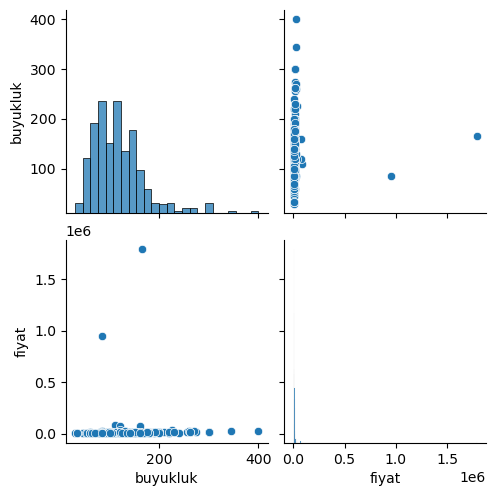

In [20]:
sns.pairplot(veri)
plt.show()

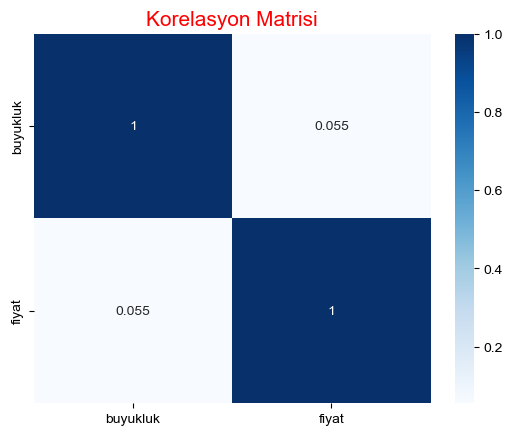

In [21]:
veri_corr=veri.corr()
plt.title("Korelasyon Matrisi", color="red", fontsize=15)
sns.heatmap(veri_corr,annot=True,cmap="Blues")
sns.set(font_scale=2,style='white')
plt.show()

Sayısal değişkenler arasında doğrusal ilişkinin olmadığını söyleyebiliriz.

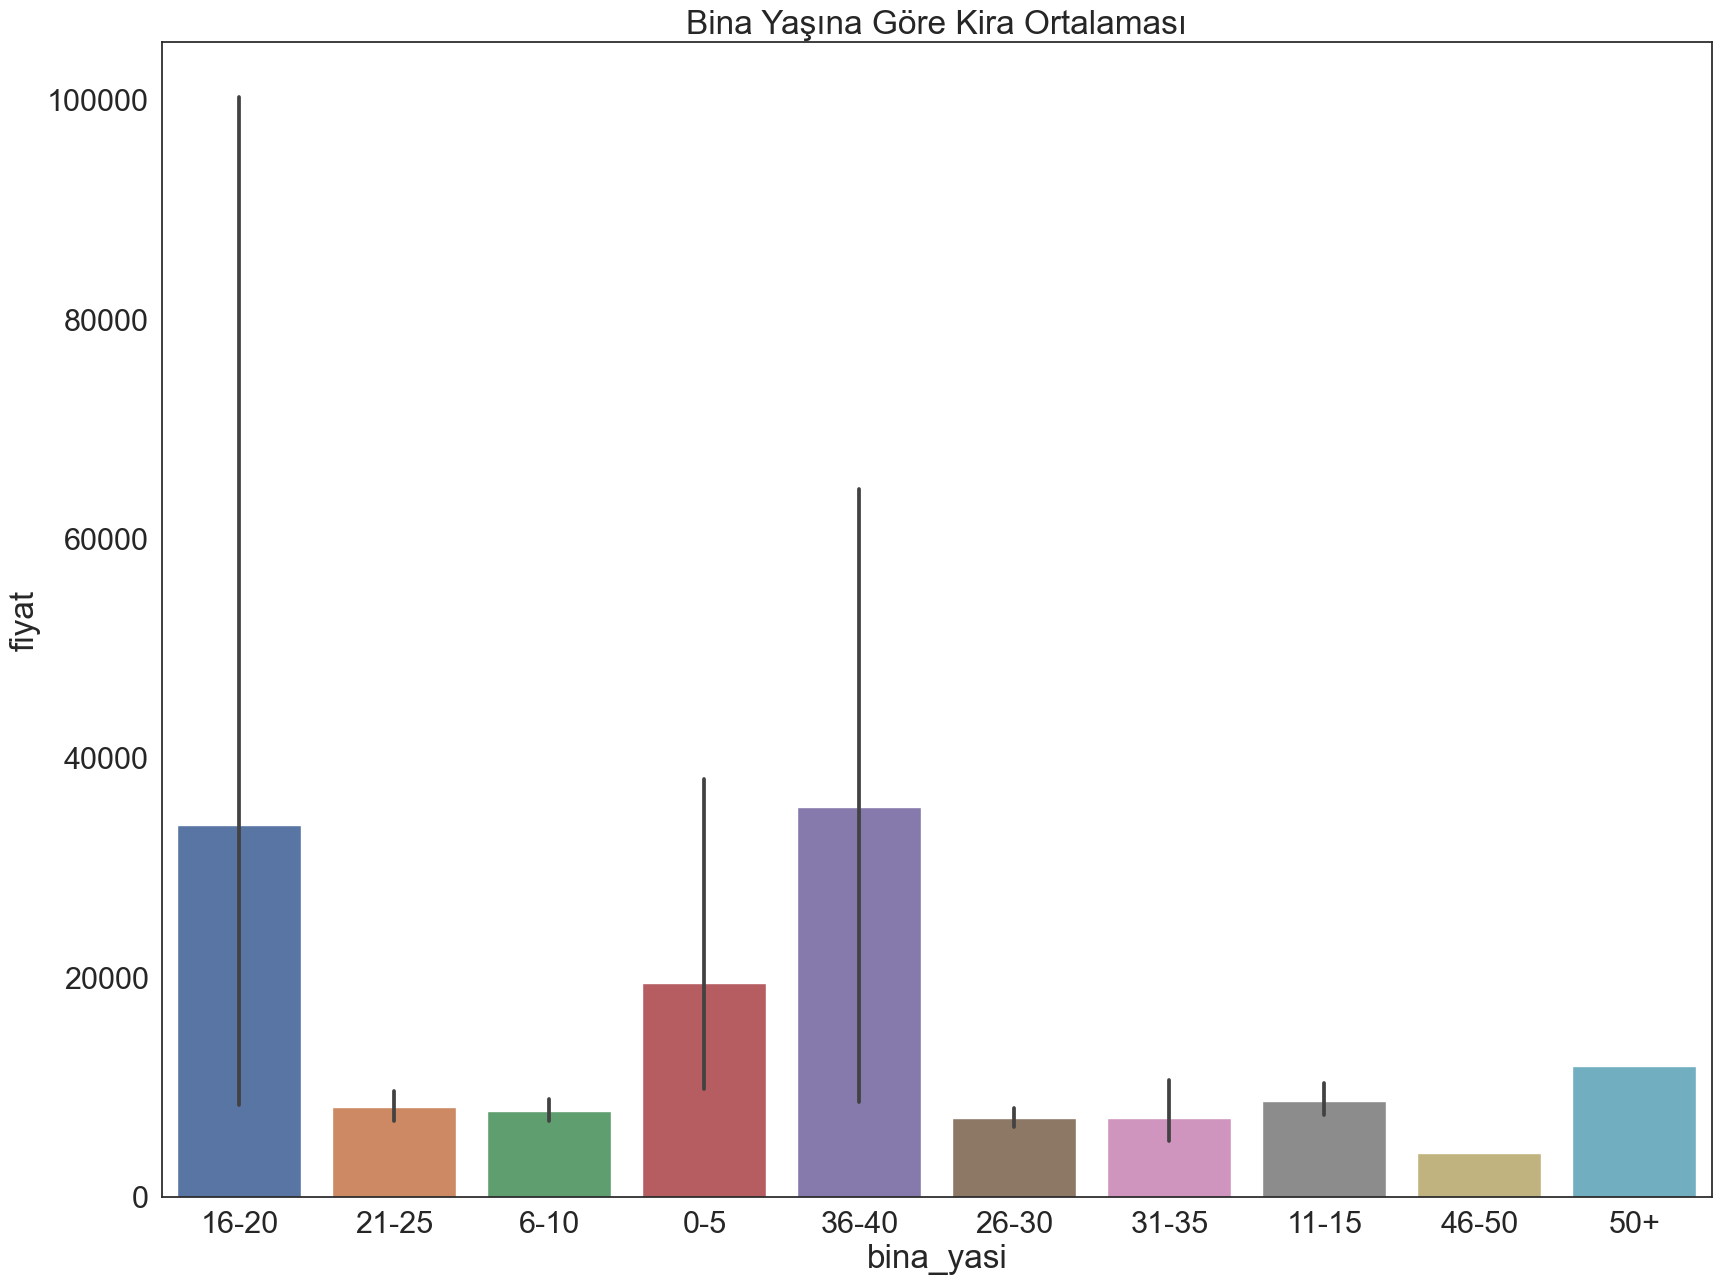

In [22]:
plt.figure(figsize=(20,15))
sns.barplot(x = "bina_yasi", y = "fiyat", data = veri)
plt.title("Bina Yaşına Göre Kira Ortalaması")
plt.show()

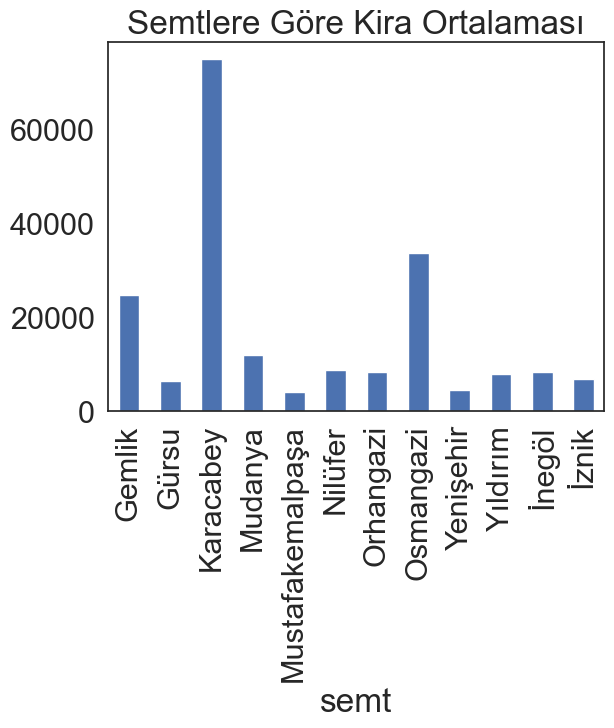

In [23]:
# semtlere göre kira ortalaması
veri.groupby("semt")["fiyat"].mean().plot(kind="bar")
plt.title("Semtlere Göre Kira Ortalaması")
plt.show()

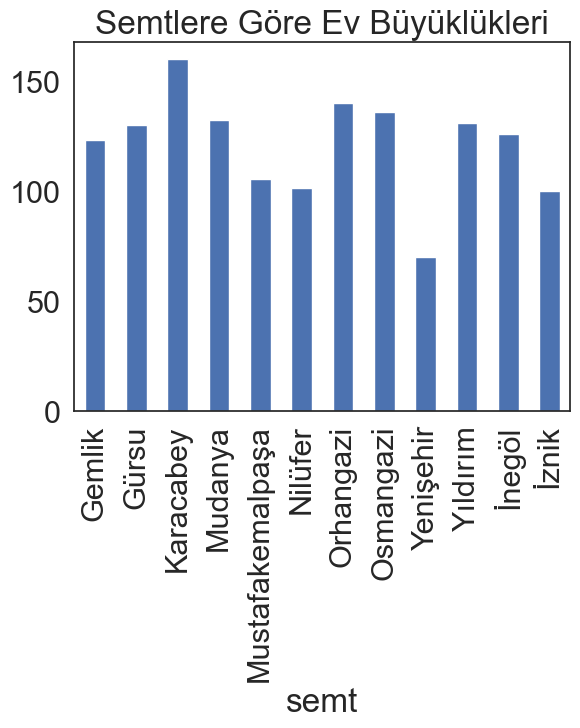

In [24]:
veri.groupby("semt")["buyukluk"].mean().plot(kind="bar")
plt.title("Semtlere Göre Ev Büyüklükleri")
plt.show()

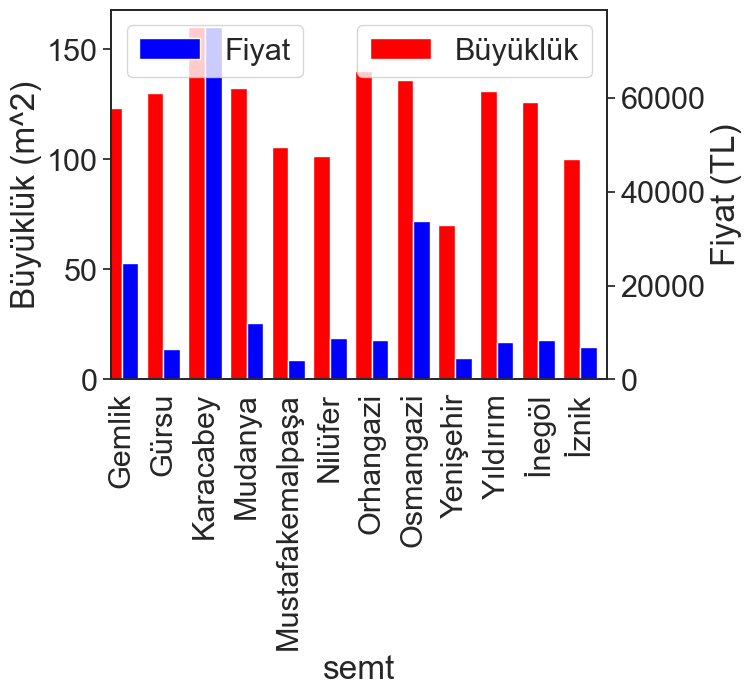

In [25]:
fig=plt.figure()
ax=fig.add_subplot()
ax2=ax.twinx()
width = 0.4

veri.groupby("semt")["buyukluk"].mean().plot(kind='bar', color='red', ax=ax, width=width, position=1,label="Büyüklük")
veri.groupby("semt")["fiyat"].mean().plot(kind='bar', color='blue', ax=ax2, width=width, position=0,label="Fiyat")

ax.set_ylabel('Büyüklük (m^2)')
ax2.set_ylabel('Fiyat (TL)')
ax.legend()
ax2.legend(loc="upper left")

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


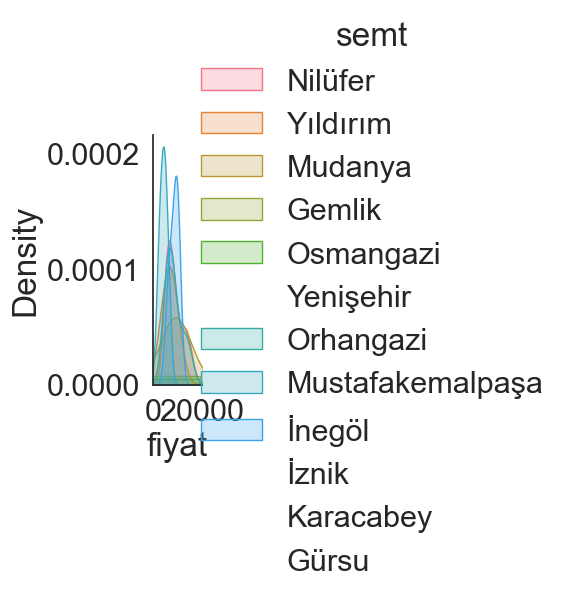

In [26]:
sns.FacetGrid(veri,hue = "semt",height = 4,xlim = (0, 20000)).map(sns.kdeplot, "fiyat", shade= True).add_legend()
plt.show()

## Aykırı Değerlerin Tespiti

In [9]:
veri.columns

Index(['ilan_adi', 'oda_sayisi', 'buyukluk', 'bina_yasi', 'kat', 'semt',
       'fiyat'],
      dtype='object')

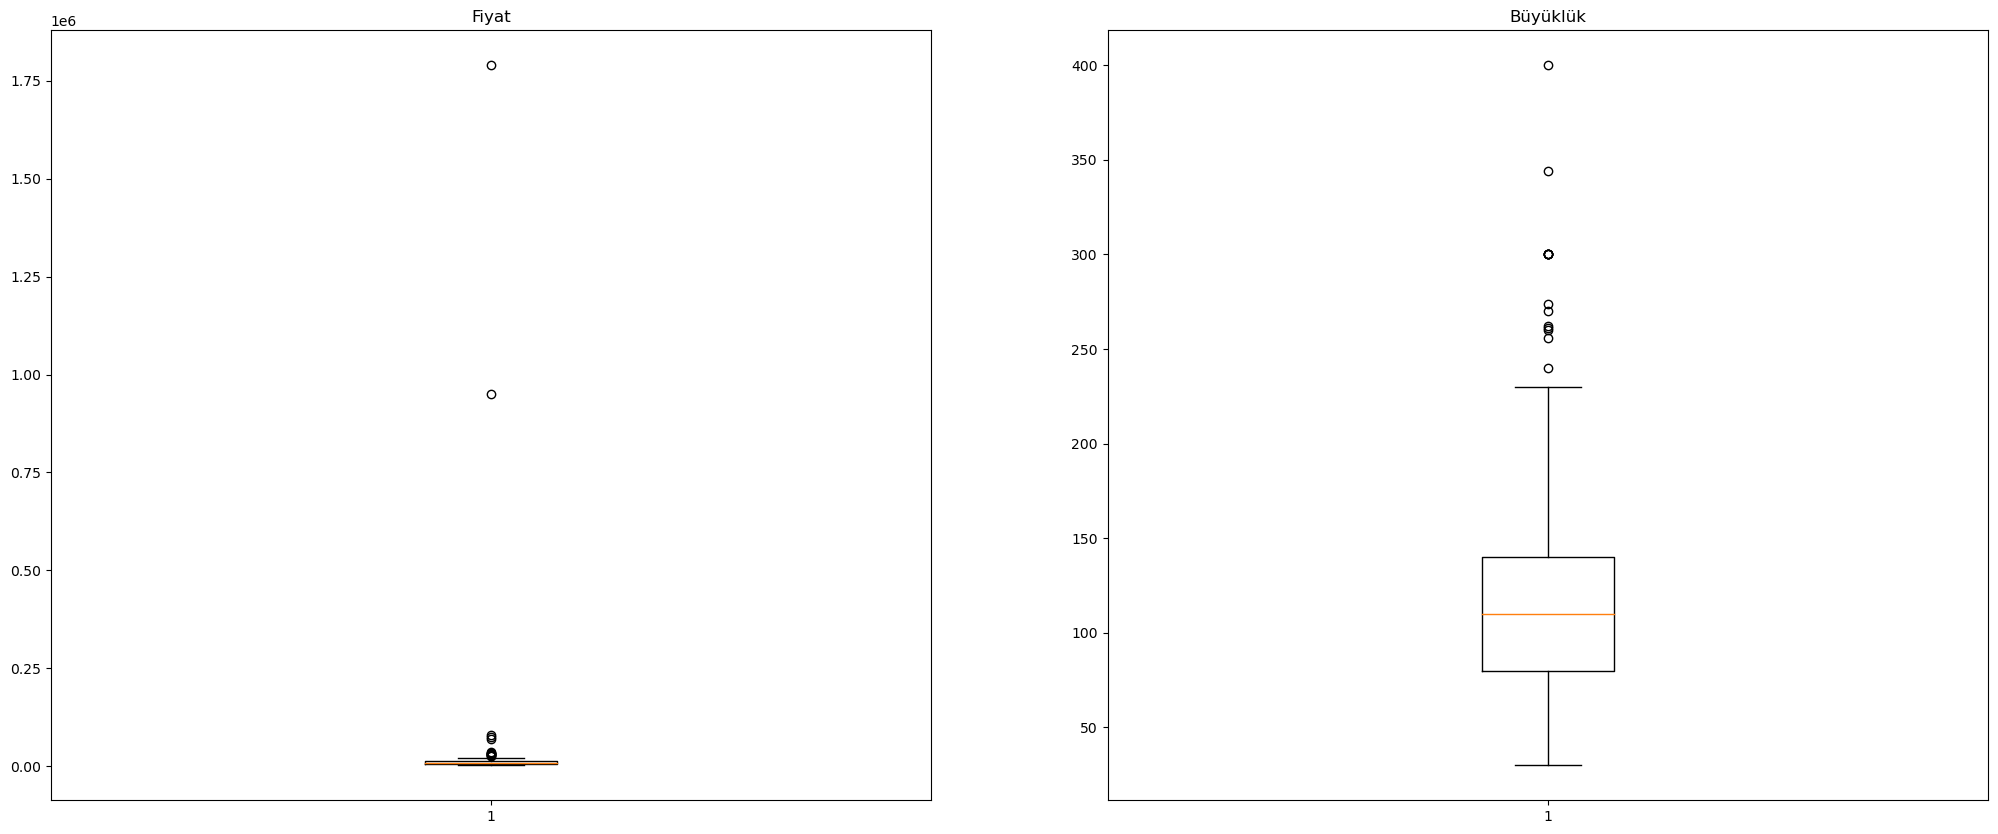

In [10]:
fig,ax=plt.subplots(1,2,figsize=(25,10))
ax[0].boxplot(veri["fiyat"])
ax[0].set_title("Fiyat")
ax[1].boxplot(veri["buyukluk"])
ax[1].set_title("Büyüklük")
plt.show()

In [11]:
veri["oda_sayisi"].unique()

array(['3 + 1', '2 + 1', '1 + 1', '4 + 1', 'Stüdyo', '5 + 1', '2 + 11',
       '5 + 2', '2 + 2', '1 + 3', '2 + 0', '6 + 1', '3 + 2'], dtype=object)

In [12]:
for i in range(len(veri)):
    if veri["oda_sayisi"][i]=="1 + 3":
        veri["oda_sayisi"][i]="3 + 1"

C:\Users\okand\AppData\Local\Temp\ipykernel_9724\1319586928.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veri["oda_sayisi"][i]="3 + 1"


In [13]:
veri["oda_sayisi"].unique()

array(['3 + 1', '2 + 1', '1 + 1', '4 + 1', 'Stüdyo', '5 + 1', '2 + 11',
       '5 + 2', '2 + 2', '2 + 0', '6 + 1', '3 + 2'], dtype=object)

In [14]:
veri=veri.drop(index=veri[veri["oda_sayisi"]=="16 + 4"].index,axis=0) # Aykırı gözlemlerden birini eğledik

In [15]:
def aykiri_index(data,col):
    q1=data[col].quantile(0.25)
    q3=data[col].quantile(0.75)
    IQR=q3-q1

    altsinir=q1-1.5*IQR
    ustsinir=q3+1.5*IQR

    aykırımin=data[data[col]<altsinir][col]
    aykırımax=data[data[col]>ustsinir][col]

    aykırı=pd.concat([aykırımin,aykırımax], axis=0).index
    return aykırı, altsinir, ustsinir

In [16]:
aykiri_fiyat_index=aykiri_index(veri,"fiyat")[0]
aykiri_buyukluk_index=aykiri_index(veri,"buyukluk")[0]

Aykırı değerleri katrgori kırılımı ortalamalarına göre dolduracağım.

In [17]:
for i in veri.loc[aykiri_fiyat_index].index:
    veri["fiyat"][i]=veri.groupby("oda_sayisi")["fiyat"].mean()[veri["oda_sayisi"][i]]
    
for i in veri.loc[aykiri_buyukluk_index].index:
    veri["buyukluk"][i]=veri.groupby("oda_sayisi")["buyukluk"].mean()[veri["oda_sayisi"][i]]

C:\Users\okand\AppData\Local\Temp\ipykernel_9724\3894621461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veri["fiyat"][i]=veri.groupby("oda_sayisi")["fiyat"].mean()[veri["oda_sayisi"][i]]
C:\Users\okand\AppData\Local\Temp\ipykernel_9724\3894621461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veri["fiyat"][i]=veri.groupby("oda_sayisi")["fiyat"].mean()[veri["oda_sayisi"][i]]
C:\Users\okand\AppData\Local\Temp\ipykernel_9724\3894621461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

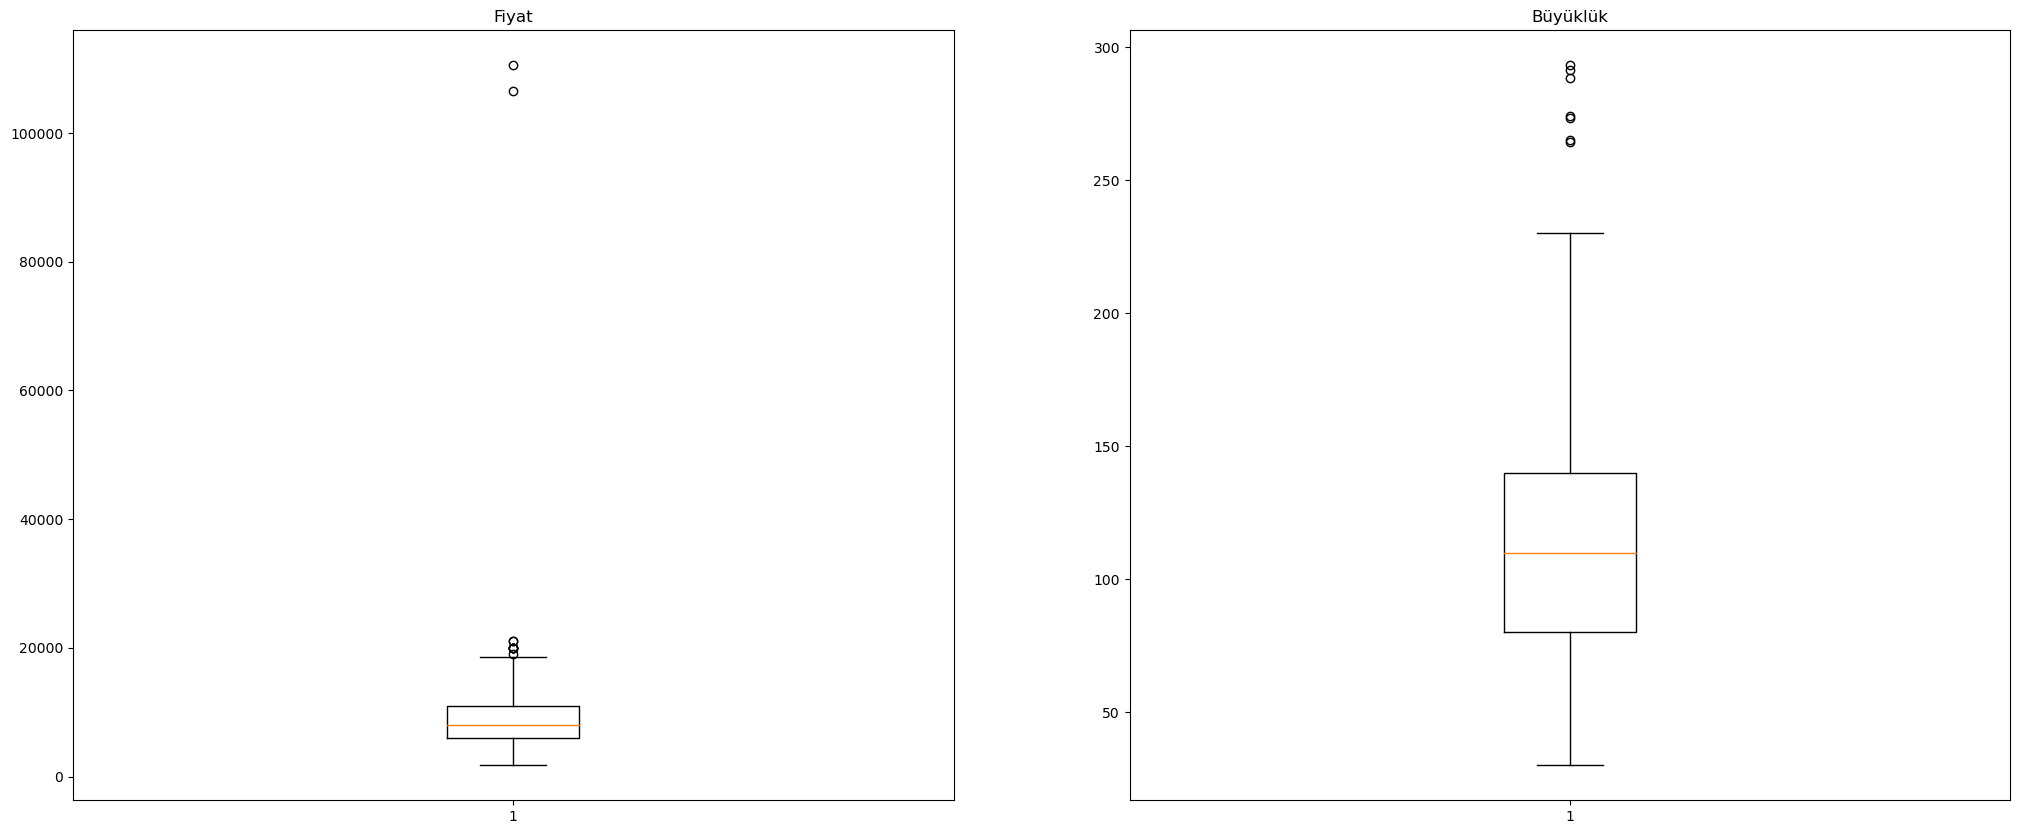

In [18]:
fig,ax=plt.subplots(1,2,figsize=(25,10))
ax[0].boxplot(veri["fiyat"])
ax[0].set_title("Fiyat")
ax[1].boxplot(veri["buyukluk"])
ax[1].set_title("Büyüklük")
plt.show()

In [19]:
veri=veri.reset_index()
veri=veri.drop(["index"],axis=1)

In [44]:
veri.loc[veri["fiyat"]>aykiri_index(veri,"fiyat")[2]]=aykiri_index(veri,"fiyat")[2]
veri.loc[veri["buyukluk"]>aykiri_index(veri,"buyukluk")[2]]=aykiri_index(veri,"buyukluk")[2]

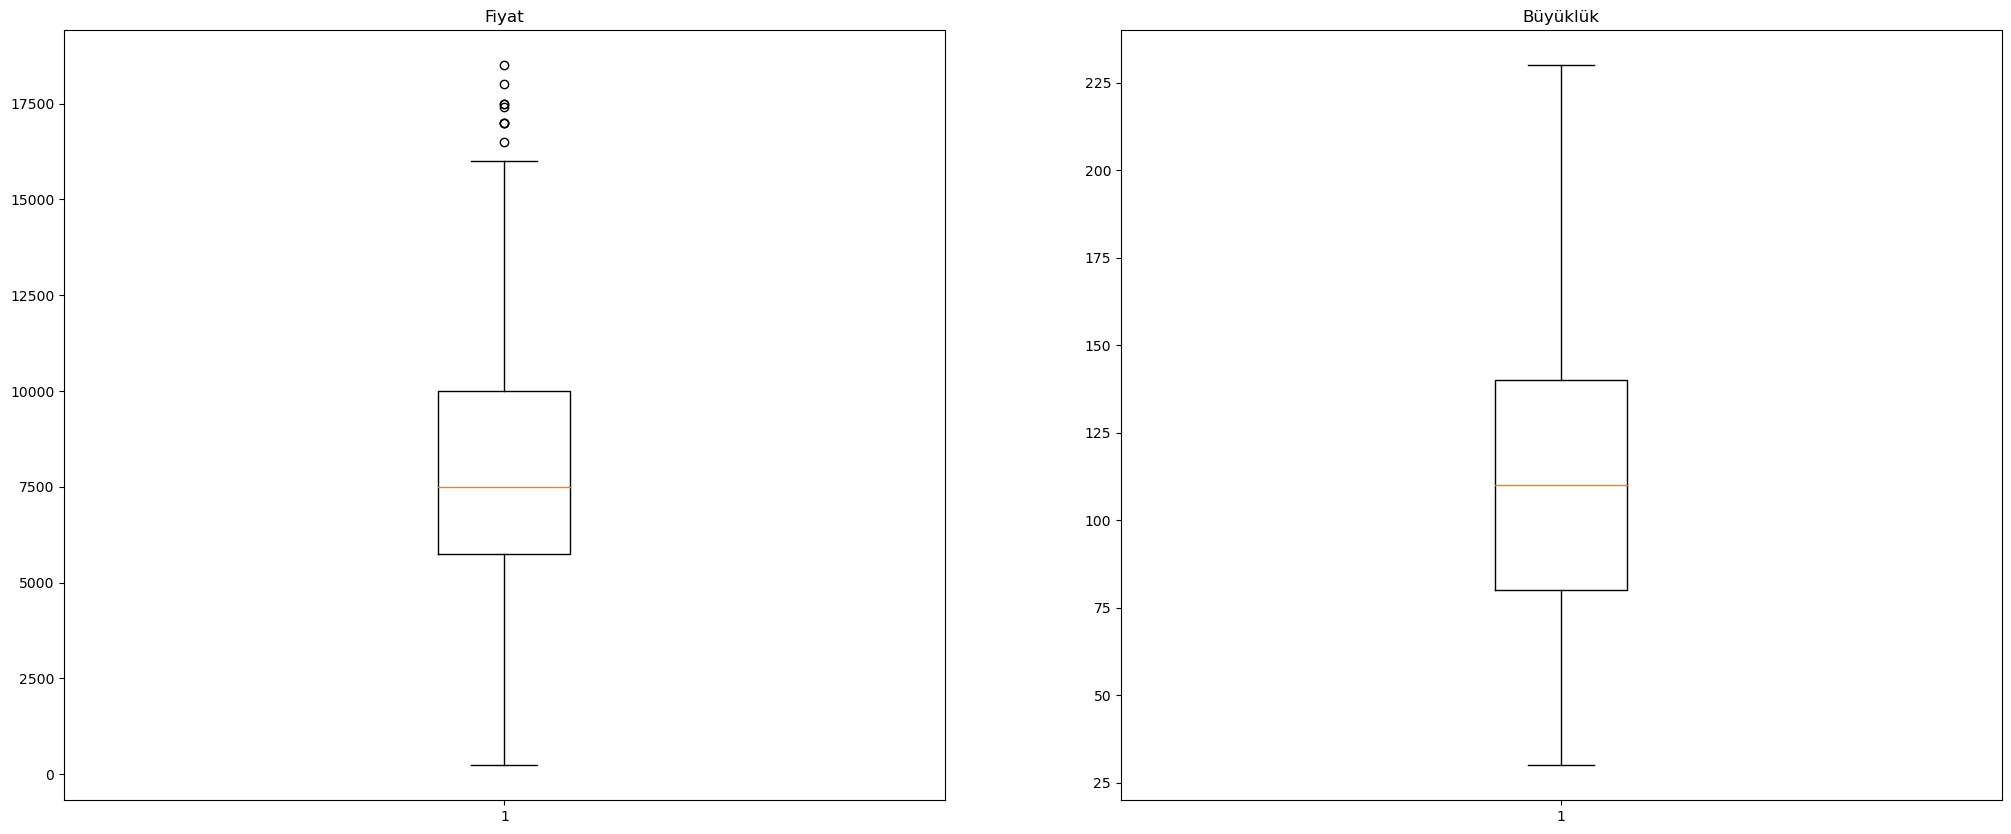

In [45]:
fig,ax=plt.subplots(1,2,figsize=(25,10))
ax[0].boxplot(veri["fiyat"])
ax[0].set_title("Fiyat")
ax[1].boxplot(veri["buyukluk"])
ax[1].set_title("Büyüklük")
plt.show()

In [46]:
veri=veri.reset_index()
veri.head()

,index,ilan_adi,oda_sayisi,buyukluk,bina_yasi,kat,semt,fiyat
0,0,zümeüt ten ihsaaniye de boş hemen taşın kiralı...,3 + 1,140.000000,16-20,5. Kat,Nilüfer,10500.0
1,1,cio gayrimenkul'den kiralık bakımlı daire,2 + 1,115.000000,21-25,2. Kat,Yıldırım,5750.0
2,2,kasa gayrimenkul'den görükle de eşyalı 1+1 kir...,1 + 1,65.000000,6-10,3. Kat,Nilüfer,4500.0
3,3,"bk yatırım'dan,mudanya'da full deniz manzaralı...",4 + 1,206.105263,0-5,5. Kat,Mudanya,15000.0
4,4,bursa nilüfer beşevler konak mh kiralık 2.kat ...,3 + 1,150.000000,21-25,2. Kat,Nilüfer,10000.0


In [47]:
veri=veri.drop(["index"],axis=1)

## Label Encoder

In [20]:
veri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ilan_adi    432 non-null    object 
 1   oda_sayisi  432 non-null    object 
 2   buyukluk    432 non-null    float64
 3   bina_yasi   432 non-null    object 
 4   kat         432 non-null    object 
 5   semt        432 non-null    object 
 6   fiyat       432 non-null    float64
dtypes: float64(2), object(5)
memory usage: 23.8+ KB


In [21]:
veri["oda_sayisi"].unique()

array(['3 + 1', '2 + 1', '1 + 1', '4 + 1', 'Stüdyo', '5 + 1', '2 + 11',
       '5 + 2', '2 + 2', '2 + 0', '6 + 1', '3 + 2'], dtype=object)

In [22]:
veri["bina_yasi"].unique()

array(['16-20', '21-25', '6-10', '0-5', '36-40', '26-30', '31-35',
       '11-15', '46-50', '50+'], dtype=object)

In [23]:
veri["kod_oda_sayisi"]=LabelEncoder().fit_transform(veri["oda_sayisi"])
veri["kod_bina_yasi"]=LabelEncoder().fit_transform(veri["bina_yasi"])
veri["kod_kat"]=LabelEncoder().fit_transform(veri["kat"])
veri["kod_semt"]=LabelEncoder().fit_transform(veri["semt"])

sıralı1=pd.Categorical(veri["oda_sayisi"], categories=["Stüdyo","1 + 1","2 + 0","2 + 1","2 + 2","3 + 1","3 + 2","4 + 1","5 + 1","5 + 2","6 + 1","2 + 11"],ordered=True)
veri["sirali_kod_oda_sayisi"],sıra1=pd.factorize(sıralı1,sort=True)

sıralı2=pd.Categorical(veri["bina_yasi"], categories=["0-5","6-10","11-15","16-20","21-25","26-30","31-35","36-40","46-50","50+"],ordered=True)
veri["sirali_kod_bina_yasi"],sıra2=pd.factorize(sıralı2,sort=True)

print(sıra1)
print(sıra2)

['Stüdyo', '1 + 1', '2 + 0', '2 + 1', '2 + 2', ..., '4 + 1', '5 + 1', '5 + 2', '6 + 1', '2 + 11']
Length: 12
Categories (12, object): ['Stüdyo' < '1 + 1' < '2 + 0' < '2 + 1' ... '5 + 1' < '5 + 2' < '6 + 1' < '2 + 11']
['0-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35', '36-40', '46-50', '50+']
Categories (10, object): ['0-5' < '6-10' < '11-15' < '16-20' ... '31-35' < '36-40' < '46-50' < '50+']


In [24]:
veri

,ilan_adi,oda_sayisi,buyukluk,bina_yasi,kat,semt,fiyat,kod_oda_sayisi,kod_bina_yasi,kod_kat,kod_semt,sirali_kod_oda_sayisi,sirali_kod_bina_yasi
0,zümeüt ten ihsaaniye de boş hemen taşın kiralı...,3 + 1,140.000000,16-20,5. Kat,Nilüfer,10500.0,5,2,12,5,5,3
1,cio gayrimenkul'den kiralık bakımlı daire,2 + 1,115.000000,21-25,2. Kat,Yıldırım,5750.0,2,3,8,9,3,4
2,kasa gayrimenkul'den görükle de eşyalı 1+1 kir...,1 + 1,65.000000,6-10,3. Kat,Nilüfer,4500.0,0,9,10,5,1,1
3,"bk yatırım'dan,mudanya'da full deniz manzaralı...",4 + 1,206.105263,0-5,5. Kat,Mudanya,15000.0,7,0,12,3,7,0
4,bursa nilüfer beşevler konak mh kiralık 2.kat ...,3 + 1,150.000000,21-25,2. Kat,Nilüfer,10000.0,5,3,8,5,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,çekirge cd kültürpark karşısı kombili kiralık ...,3 + 1,160.000000,31-35,2. Kat,Osmangazi,8500.0,5,5,8,7,5,6
428,özlüce 1+1 kiralik daire,1 + 1,70.000000,0-5,4. Kat,Nilüfer,8000.0,0,0,11,5,1,0
429,sahibinden kiralık eşyalı daire,2 + 1,85.000000,31-35,6. Kat,Osmangazi,6750.0,2,5,13,7,3,6
430,2+1 bahçe katı 7500tl altınşehir de kiralik d...,2 + 1,100.000000,0-5,Zemin,Nilüfer,7500.0,2,0,26,5,3,0


In [25]:
veri2=veri[["sirali_kod_oda_sayisi","buyukluk","sirali_kod_bina_yasi","kod_kat","kod_semt","fiyat"]]
veri2=veri2.rename(columns={"sirali_kod_oda_sayisi":"oda_sayisi","sirali_kod_bina_yasi":"bina_yasi","kod_kat":"kat","kod_semt":"semt"})
veri2.head()

,oda_sayisi,buyukluk,bina_yasi,kat,semt,fiyat
0,5,140.000000,3,12,5,10500.0
1,3,115.000000,4,8,9,5750.0
2,1,65.000000,1,10,5,4500.0
3,7,206.105263,0,12,3,15000.0
4,5,150.000000,4,8,5,10000.0


In [26]:
veri2[["oda_sayisi","bina_yasi","kat","semt"]]=veri2[["oda_sayisi","bina_yasi","kat","semt"]].astype(object)
veri2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   oda_sayisi  432 non-null    object 
 1   buyukluk    432 non-null    float64
 2   bina_yasi   432 non-null    object 
 3   kat         432 non-null    object 
 4   semt        432 non-null    object 
 5   fiyat       432 non-null    float64
dtypes: float64(2), object(4)
memory usage: 20.4+ KB


## One-Hot Dönüşümü

In [27]:
onehotdonusum=pd.get_dummies(veri2,columns=["oda_sayisi","bina_yasi","kat","semt"],drop_first=True)
print(onehotdonusum)

       buyukluk    fiyat  oda_sayisi_1  oda_sayisi_2  oda_sayisi_3  \
0    140.000000  10500.0             0             0             0   
1    115.000000   5750.0             0             0             1   
2     65.000000   4500.0             1             0             0   
3    206.105263  15000.0             0             0             0   
4    150.000000  10000.0             0             0             0   
..          ...      ...           ...           ...           ...   
427  160.000000   8500.0             0             0             0   
428   70.000000   8000.0             1             0             0   
429   85.000000   6750.0             0             0             1   
430  100.000000   7500.0             0             0             1   
431   33.000000   3500.0             0             0             0   

     oda_sayisi_4  oda_sayisi_5  oda_sayisi_6  oda_sayisi_7  oda_sayisi_8  \
0               0             1             0             0             0   
1    

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [28]:
veri3=onehotdonusum
veri3.head()

,buyukluk,fiyat,oda_sayisi_1,oda_sayisi_2,oda_sayisi_3,oda_sayisi_4,oda_sayisi_5,oda_sayisi_6,oda_sayisi_7,oda_sayisi_8,...,semt_2,semt_3,semt_4,semt_5,semt_6,semt_7,semt_8,semt_9,semt_10,semt_11
0,140.000000,10500.0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,115.000000,5750.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,65.000000,4500.0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,206.105263,15000.0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,150.000000,10000.0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


# Regresyon Modelleri

In [29]:
y=veri3["fiyat"]
X=veri3.drop(columns=["fiyat"])
print(X.shape)

(432, 59)


In [30]:
# Standartlaştırma:
sc=StandardScaler()
X=sc.fit_transform(X)

In [31]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=42)
print(X_train.shape)
print(X_test.shape)

(367, 59)
(65, 59)


In [32]:
## Model Tuning
lambdalar=10**np.linspace(10,-2,100)*0.5

ridge_cv=RidgeCV(alphas=lambdalar,scoring="r2") # optimal alpha değeri tahmin etmeye çalışacağız.
ridge_cv.fit(X_train,y_train)
lasso_cv=LassoCV(cv=10,max_iter=10000).fit(X_train,y_train).alpha_
elasticnet_cv=ElasticNetCV(cv=10,max_iter=10000).fit(X_train,y_train).alpha_
print("Ridge Alpha: ",ridge_cv.alpha_)
print("Lasso Alpha: ",lasso_cv)
print("Elasticnet Alpha: ",elasticnet_cv)

Ridge Alpha:  616.4233697210329
Lasso Alpha:  3908.679707955603
Elasticnet Alpha:  7.817359415911206


In [33]:
# Modeller:

def caprazdog(model):
    dogruluk=cross_val_score(model,X,y,cv=10) # 10 kat parçalama yapar
    return dogruluk.mean() # her bir modelin çapraz doğrulama score başarısı hakkında genel bir bilgi alacağız.

def basari(gercek,tahmin):
    rmse=mt.mean_squared_error(gercek,tahmin,squared=True)
    r2=mt.r2_score(gercek,tahmin)
    return[rmse,r2]


ridge_model=Ridge(alpha=616.4233697210329)
ridge_model.fit(X_train,y_train)
ridge_tahmin=ridge_model.predict(X_test)

lasso_model=Lasso(alpha=3908.679707955603)
lasso_model.fit(X_train,y_train)
lasso_tahmin=lasso_model.predict(X_test)

elas_model=ElasticNet(alpha=7.817359415911206)
elas_model.fit(X_train,y_train)
elas_tahmin=elas_model.predict(X_test)

sonuclar=[["Ridge Model",basari(y_test,ridge_tahmin)[0],basari(y_test,ridge_tahmin)[1],caprazdog(ridge_model)],
["Lasso Model",basari(y_test,lasso_tahmin)[0],basari(y_test,lasso_tahmin)[1],caprazdog(lasso_model)],
["ElasticNet Model",basari(y_test,elas_tahmin)[0],basari(y_test,elas_tahmin)[1],caprazdog(elas_model)]]

pd.options.display.float_format='{:,.4f}'.format
sonuclar=pd.DataFrame(sonuclar, columns=["Model","RMSE","R2","Doğrulama"])
sonuclar

,Model,RMSE,R2,Doğrulama
0,Ridge Model,"9,202,944.2215",0.3700,0.0613
1,Lasso Model,"14,734,466.2997",-0.0087,-0.0783
2,ElasticNet Model,"10,599,314.9231",0.2744,0.0933


## Karar Ağaçları:

In [34]:
modeller=["SVR","DecisionTreeRegressor","BaggingRegressor","RandomForestRegressor"]
regresyonlar=[SVR(),DecisionTreeRegressor(random_state=0),
              BaggingRegressor(random_state=0),RandomForestRegressor(random_state=0)]
parametreler={
    modeller[0]:{"kernel":["linear","poly","rbf"],"C":[1,10,100,1000,10000],"gamma":[1,0.1,0.001]},
    modeller[1]:{"min_samples_split":range(2,25),"max_leaf_nodes":range(2,25)},
    modeller[2]:{"n_estimators":range(2,25)},
    modeller[3]:{"max_depth":range(2,20),"max_features":range(2,20),"n_estimators":range(2,20)}
}

In [35]:
def cozum(model):
    model.fit(X_train,y_train)
    return model

def skor(model2):
    tahmin=cozum(model2).predict(X_test)
    r2=mt.r2_score(y_test,tahmin)
    rmse=mt.mean_squared_error(y_test,tahmin,squared=True)
    return [r2,rmse]

In [36]:
## Model Tuning:
for i,j in zip(modeller,regresyonlar):
    print(i)
    grid=GridSearchCV(cozum(j),parametreler[i],cv=5)
    grid.fit(X_train,y_train)
    print(grid.best_params_)

SVR
{'C': 1000, 'gamma': 1, 'kernel': 'linear'}
DecisionTreeRegressor
{'max_leaf_nodes': 3, 'min_samples_split': 10}
BaggingRegressor
{'n_estimators': 4}
RandomForestRegressor
{'max_depth': 13, 'max_features': 5, 'n_estimators': 12}


In [42]:
sonuc=[]
regresyonlar2=[SVR(C=1000,gamma=1,kernel="linear"),DecisionTreeRegressor(random_state=0,max_leaf_nodes=3,min_samples_split=10),
              BaggingRegressor(random_state=0,n_estimators=4),RandomForestRegressor(random_state=0,max_depth=13,max_features=5,n_estimators=12)]


for i in regresyonlar2:
    sonuc.append(skor(i))

df=pd.DataFrame(modeller,columns=["Model Adı"])
df2=pd.DataFrame(sonuc,columns=["R2","RMSE"])

df=df.join(df2)
print(df)

               Model Adı      R2            RMSE
0                    SVR  0.5394  6,728,403.8380
1  DecisionTreeRegressor  0.2430 11,057,041.8417
2       BaggingRegressor  0.4503  8,029,429.6212
3  RandomForestRegressor -0.1401 16,652,632.5651


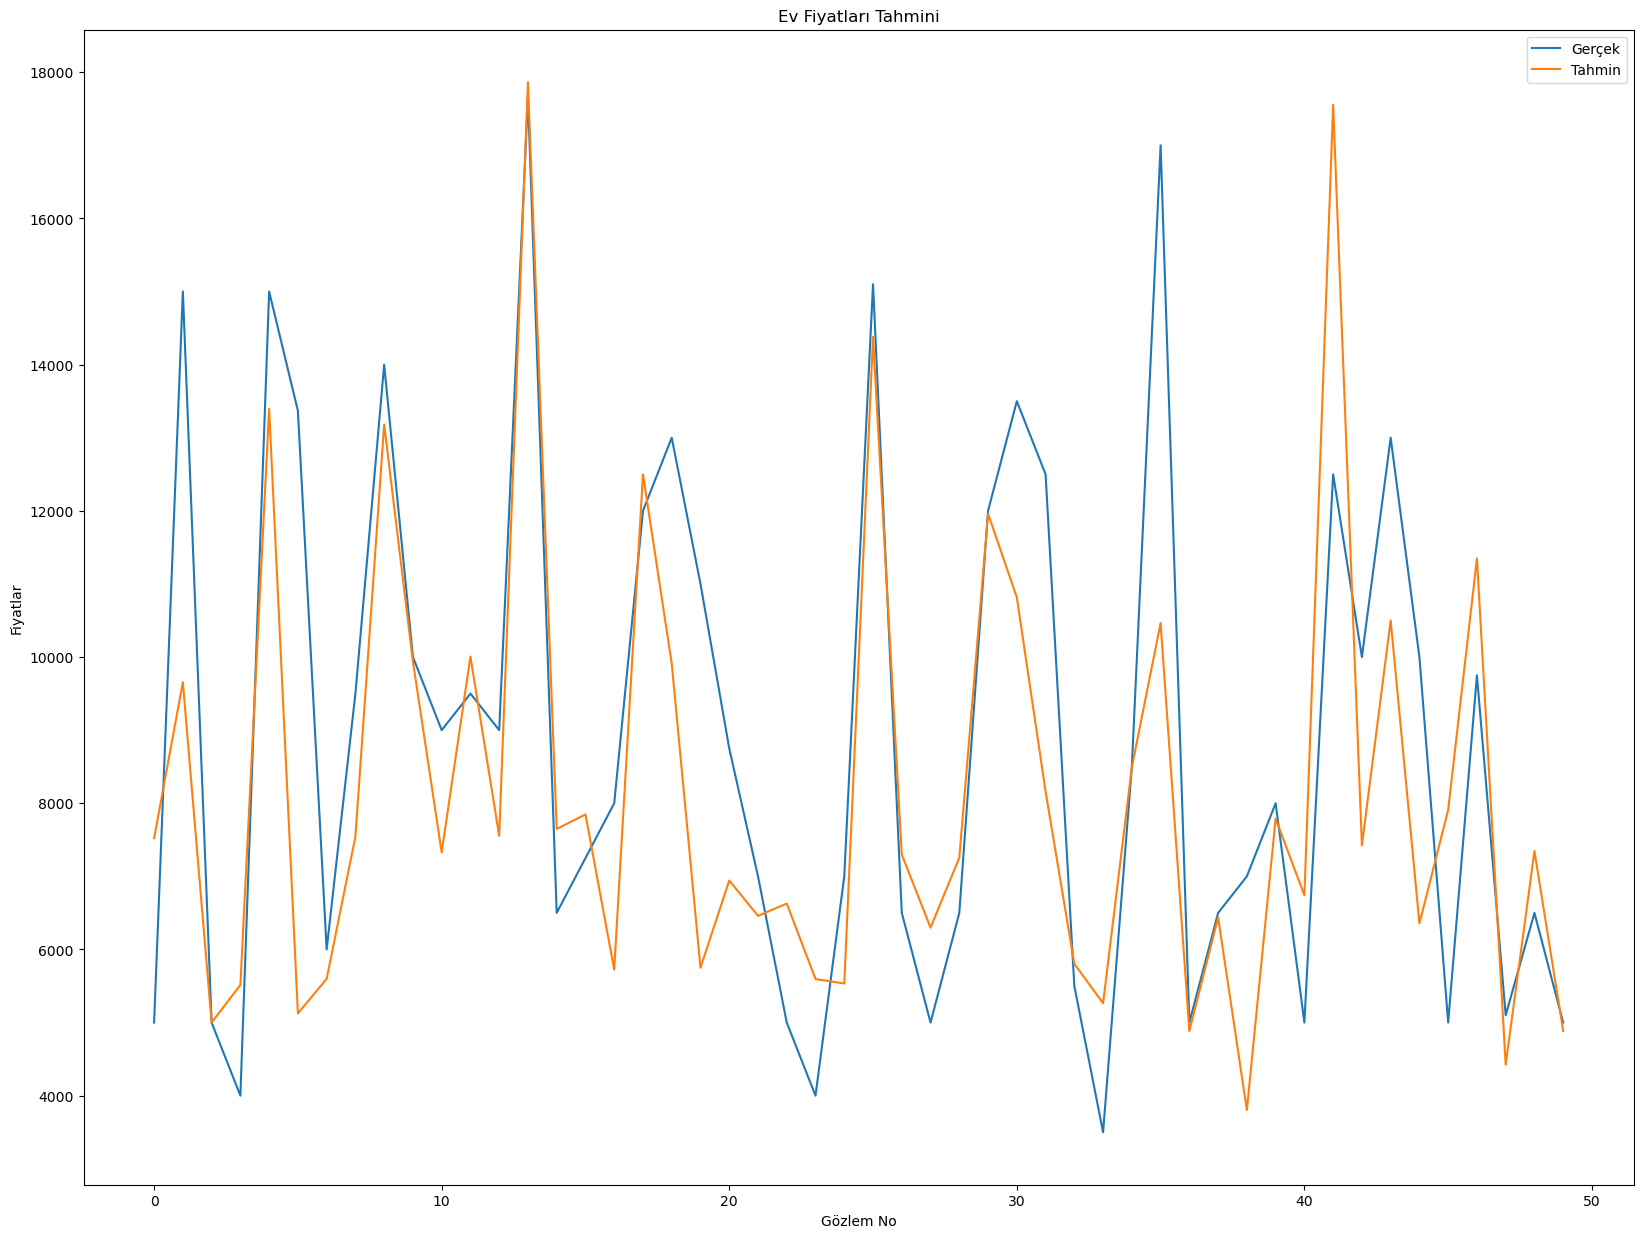

In [46]:
svrrbf=SVR(kernel="linear", C=1000, gamma=1) 
svrrbf.fit(X_train,y_train)
tahminrbf=svrrbf.predict(X_test)

plt.figure(figsize=(20,15))
plt.plot(range(len(y_test[:50])),y_test[:50],label="Gerçek")
plt.plot(range(len(y_test[:50])),tahminrbf[:50],label="Tahmin")
plt.title("Ev Fiyatları Tahmini")
plt.ylabel("Fiyatlar")
plt.xlabel("Gözlem No")
plt.legend()
plt.show()